In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from glob import glob
import sys, os
import xarray
import ngl
import numpy
from e3smplot.e3sm_utils import area_average, open_dataset, get_mapping_file
from e3smplot.e3sm_utils import get_grid_name, can_retrieve_field, is_latlon
from e3smplot.pyngl import compare_maps
from e3smplot.mpl import compare_time_series, compare_zonal_means
import os.path
import datetime

In [4]:
# A short, meaningful name with which to label plots and set output filenames.
# Does not need to match the case name of the model run, but does need to match
# one of the data_paths keys below!
test_case_name = 'Run 2'

# Set control case names. We will compare the test_case_name against each of
# these
cntl_case_names = ('CERES-SYN', 'ERA5', )#'GPM') #'ne1024 Oct9', 'CERES-SYN', 'ERA5')

# Path were we can find netcdf files with output from the test/model case
data_paths = {
    # Raw files
    #'Run 1' : '/global/cscratch1/sd/terai/e3sm_scratch/cori-knl/20201112.SCREAMv0dyamond2.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16/run',
    #'Run 2': '/global/cscratch1/sd/terai/e3sm_scratch/cori-knl/SCREAMv0.SCREAM-DY2.ne1024pg2.20201127/run',
    # Regridded files
    'Run 1' : '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201112/regridded',
    'Run 2' : '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127/regridded',
    'ne4pg2': '/global/cscratch1/sd/bhillma/e3sm_scratch/cori-knl/20201112.dyamond2.F2010-SCREAM-HR.ne4pg2_ne4pg2.cori-knl.2x42x2/run',
    'ne1024 Oct9' : '/global/cscratch1/sd/terai/e3sm_scratch/cori-knl/master.ne1024pg2_r0125_oRRS18to6v3.F2010-SCREAM-HR-DYAMOND2.cori-knl_intel.1536x8x16.DY2_Oct9.20201009-16/run',
    'ne256 lamlow': '/global/cscratch1/sd/bogensch/E3SM_simulations/master.ne256pg2_r0125_oRRS18to6v3.F2010-SCREAM-HR-DYAMOND2.cori-knl_intel.1024x16x8.DY2_Oct6.20201022-16.lamlow.001a/run',
    'ne256 rrtmg' : '/global/cscratch1/sd/bhillma/scream/cases/9bfb38267.ne256pg2_r0125_oRRS18to6v3.F2010-SCREAM-HR-DYAMOND2.cori-knl_intel.192x16x8.rrtmg.20201021-0921/run',
    'ne256 rrtmgp': '/global/cscratch1/sd/bhillma/scream/cases/9bfb38267.ne256pg2_r0125_oRRS18to6v3.F2010-SCREAM-HR-DYAMOND2.cori-knl_intel.192x16x8.rrtmgp.20201021-1722/run',
    'ne4 rrtmg': '/global/cscratch1/sd/bhillma/e3sm_scratch/cori-knl/SMS_Ld5.ne4_ne4.FC5AV1C-L.cori-knl_intel.add-optics-outputs/run',
    'ne4 rrtmgp': '/global/cscratch1/sd/bhillma/e3sm_scratch/cori-knl/SMS_Ld5.ne4_ne4.FC5AV1C-L.cori-knl_intel.cam-rrtmgp.add-optics-outputs/run',
    'ne1024 Nov05': '/global/cscratch1/sd/terai/E3SM_simulations/master.ne1024pg2_r0125_oRRS18to6v3.F2010-SCREAM-HR-DYAMOND2.cori-knl_intel.1536x8x16.DY2_Nov05branch_SHOC_P3_AB_bugfix.20201105-16',
    'CERES-SYN': '/global/cfs/cdirs/e3sm/terai/Obs_datasets/CERES',
    'ERA5': '/global/cfs/cdirs/e3sm/bhillma/obs_datasets/ERA5',
    'GPM': '/global/cfs/cdirs/e3sm/terai/Obs_datasets/GPM',
}

# List of fields we want to make map plots for
variables = (
    # 3D vars
    # TODO: do something useful with these
    #'CLOUD', 'EMIS', 'TOT_CLD_VISTAU',
    #'TOT_ICLD_VISTAU', 'LIQ_ICLD_VISTAU', 'ICE_ICLD_VISTAU',
    # 
    # 2D vars
    #'FSNTOA', 'FSNTOAC', 'FLNT', 'FLNTC', 'RESTOM',
    #'PRECT',
    #'CLDTOT', #'CLDLOW', 'CLDMED', 'CLDHGH',
    #'TMCLDLIQ', 'TMCLDICE',
    #'SHFLX', 'TREFHT', 'TMQ',
    'RESTOM',
)

# Glob strings for searching for case files. For model cases, you may want to
# search for different history tapes (h0, h1, h2, etc). 
# For some of the obs datasets, we have separate files for different categories
# of fields.
glob_strings = {
    #'ERA5': {v: '*.nc' for v in variables},
    'ERA5': {'PRECT' : 'ERA5_surf_2020*.nc',
             'SHFLX' : 'ERA5_surf_2020*.nc',
             'TREFHT': 'ERA5_surf_2020*.nc',
             'TMQ'   : 'ERA5_surf_2020*.nc',},
    'GPM': {'PRECT' : '*.2020*.nc',},
    'MAC': {'TMCLDLIQ': 'maclwp_cloudlwpave_*',
            'TOTALLWP': 'maclwp_totallwpave_*'},
    'CERES-SYN': {v: '*_20200101-20200229.nc' for v in variables},
    # For model-model comparisons, need to specify history tape number
    'ne1024 Oct9': {v: '*.h1.*.nc' for v in variables},
    'ne1024 rrtmg': {v: '*.h1.*.nc' for v in variables},
    'ne256 rrtmg' : {v: '*.h1.*.nc' for v in variables},
    'ne256 rrtmgp': {v: '*.h1.*.nc' for v in variables},
    'ne256 lamlow': {v: '*.h1.*.nc' for v in variables},
    'ne4 rrtmg': {v: '*.h0.*.nc' for v in variables},
    'ne4 rrtmgp': {v: '*.h0.*.nc' for v in variables},
    # Map variables to files for SCREAM-HR production run.
    # TODO: make this more flexible
    'Run 1': {v: '20201112.SCREAMv0dyamond2.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16.eam.h[0-9]*.nc' for v in variables},
    'Run 2': {v: 'SCREAMv0.SCREAM-DY2.ne1024pg2.20201127.eam.h[0-9]*.nc' for v in variables},
    'ne4pg2': {v: '*.eam.h[0-9]*.nc' for v in variables},

}

# Time offsets; hack so we can compare F-cases.
# HOW TO USE THIS FEATURE: in the event that you want to compare a run for a
# different time period that what we have observations for, you can use this to
# manually adjust the time coordinate of the simulation. This is certainly a
# hack, but allows us to use my code that attempts to find an overlapping time
# period to compare with the correct observations. This is a list of time
# offsets for the "test" (run you want to evaluate) and "cntl" (run or obs you
# want to evaluate against) cases. It should be a datetime.timedelta object. As
# an example for usage, say you meant to start a run for the DYAMOND2 period
# (2020-01-20), but accidentally ran an F-case (0001-01-01). We want a time
# offset in that case of 365 * 2019 + 20 days. Any entries in this list that are
# None type will not add an offset (the default behavior).
#time_offsets = [datetime.timedelta(days=(365*2019+20)), None]
time_offsets = {c: None for c in [test_case_name, *cntl_case_names]}
time_offsets['ne256 lamlow'] = datetime.timedelta(days=(365*2019+20))
time_offsets['ne4 rrtmgp'] = datetime.timedelta(days=(365*2000))
time_offsets['ne4 rrtmg'] = datetime.timedelta(days=(365*2000))

# Where should we write the plot files?
tmp_name = test_case_name.replace(' ', '_')
graphics_root = f'./graphics/{tmp_name}'
#graphics_root = f'/global/cfs/cdirs/e3sm/www/bhillma/scream/dyamond2/graphics/{tmp_name}'

# Where we keep our grids and map files. Make sure this is in scratch space,
# these things can get quite large
mapping_root = '/global/cscratch1/sd/bhillma/grids'

# Flags to control what kind of plots to make. You probably want to make them
# all, but being able to disable for testing is useful. Some of them take quite
# a while to make.
do_contour_maps = True
do_time_series = True
do_zonal_means = True
do_anomalies = True

# Before we do anything, make sure our plot directory exists
os.makedirs(graphics_root, exist_ok=True)

In [5]:
import warnings
obs_vars = {
    'FSNTOA': ('FSNT', 'toa_sw_all_3h',),
    'TMQ': ('tcwv',),
    'CLDTOT': ('cldarea_total_3h',),
    'PRECT': ('mtpr', 'precipitationCal'),
    'SHFLX': ('msshf',),
    'TREFHT': ('t2m',),
}

def field_in_dataset(f, v):
    try:
        with xarray.open_mfdataset(f, chunks={'time': 1}, combine='by_coords', drop_variables=('P3_input_dim', 'P3_output_dim')) as ds:
            try:
                d = get_data(ds, v)
                found_var = True
            except:
                found_var = False
            #if v in ds.variables.keys():
            #    found_var = True
            #elif any([obs_var in ds.variables.keys() for obs_var in obs_vars[v]]):
            #    found_var = True
            #else:
            #    found_var = False
    except:
        warnings.warn(f'Could not open dataset {f}.')
        found_var = False
    return found_var

In [6]:
cases = (test_case_name, *cntl_case_names)

## Summary statistics

In [46]:
if False:
    from matplotlib import pyplot
    from e3smplot.e3sm_utils import get_data, get_area_weights, area_average
    import numpy
    variables = ('FSNTOA', 'TMQ', 'PRECT', 'CLDTOT', 'SHFLX', 'TREFHT')
    ref_cases = {
        'FSNTOA': 'CERES-SYN',
        'TMQ'   : 'ERA5',
        'PRECT' : 'ERA5',
        'CLDTOT': 'CERES-SYN',
        'SHFLX' : 'ERA5',
        'TREFHT': 'ERA5',
    }
    colors = {
        'Run 2'    : 'tab:blue',
        'Run 1'    : 'tab:purple',
        'ne4pg2'   : 'tab:green',
        'CERES-SYN': 'black',
        'ERA5'     : 'black',
        'Reference': 'black',
    }
    units = {
        'FSNTOA': 'W/m$^2$',
        'TMQ'   : 'mm',
        'PRECT' : 'mm/d',
        'CLDTOT': '%',
        'SHFLX' : 'W/m$^2$',
        'TREFHT': 'K',
    }
    test_cases = ('Run 2', 'Run 1')#'ne4pg2')
    # Get time range to plot over
    v = variables[0]
    files = [f for f in glob(f'{data_paths[test_case_name]}/{glob_strings[test_case_name][v]}') if can_retrieve_field(f, v)]
    with open_dataset(files, chunks={'time': 1}) as ds:
        t1 = str(min(ds.time.values))
        t2 = str(max(ds.time.values))

    print(f'Computing summary statistics for time period {t1:s} to {t2:s}')

    labeled_cases = []
    figure, axes = pyplot.subplots(1, len(variables), figsize=(10, 5))
    for ivar, v in enumerate(variables):
        ax = figure.add_axes(axes[ivar])
        cases = (ref_cases[v], *test_cases)
        for icase, case in enumerate(cases):
            print(case, v)

            # Find files
            files = [f for f in glob(f'{data_paths[case]}/{glob_strings[case][v]}') if field_in_dataset(f, v)]

            # Read data
            with open_dataset(files, chunks={'time': 1}) as ds:

                # grab data
                da = get_data(ds, v)
                wt = get_area_weights(ds)

                # Subset data in time
                da = da.sel(time=slice(t1, t2))
                if 'time' in wt.dims: wt = wt.sel(time=slice(t1, t2))

                # Compute a time-series of area-means
                a = area_average(da, wt, dims=[d for d in da.dims if d != 'time'])

                # Compute daily averages
                a = a.resample(time='1D').mean(keep_attrs=True)           

                # Compute mean for control case; used to compute relative anomalies from reference means
                a_mean = a.mean().values
                if icase == 0: a_cntl = a_mean

                # Compute anomaly and maybe scale
                #yvals = (a - a_cntl).values #/ abs(a_cntl)).values
                yvals = a.values

                # Define x-axis location for each variable/case. Optionally add some jitter to
                # the x-axis locations to scatter points horizontally a little so that we can
                # see them all without overlapping too much.
                #xvals = ((ivar + 1) * numpy.ones(len(a)) + (icase) * 0.1)
                dx = 0.1 #1.0 / len(variables)
                #plot_size = dx * (len(cases)-1)
                #plot_start = -(plot_size) / 2.0
                #plot_end = plot_start + plot_size
                xloc = icase * dx #plot_start + (icase * dx)
                xvals = numpy.random.normal(loc=xloc, size=len(a), scale=dx/10)

                # Get labels; use "Reference" for the control cases
                if icase == 0:
                    label = 'Reference'
                else:
                    label = case
                # Make sure we only label each case once
                if label in labeled_cases:
                    label=None
                else:
                    labeled_cases.append(label)

                # Make scatter plot of relative anomalies
                pl1 = ax.scatter(xvals, yvals, marker='.', alpha=0.5, color=colors[case], label=label)
                #pl2 = ax2.scatter(xvals, yvals, marker='.', alpha=0.5, color=colors[case], label=None)

                # Plot mean as a small bar
                y = numpy.mean(yvals)
                pl2  = ax.plot([xloc - dx/2.0, xloc + dx/2.0], [y, y], color=colors[case], label=None)
                # Label means for control case
                #if icase == 0: 
                #    ax.text(xloc - dx,  a_cntl, f'{a_cntl:.1f}', ha='right', va='bottom')
                #    #ax.text(xvals[0] - dx, -0.001, f'{da.attrs["units"]:^10s}', ha='right', va='top')

        if v not in units.keys(): 
            print(f'adding unit {a.units} for {v}')
            units[v] = a.units

        #ax.set_ylabel('Anomaly (scaled)')
        #ax.set_ylim([-max(abs(numpy.array(ax.get_ylim()))), max(abs(numpy.array(ax.get_ylim())))])
        #xticks = [i + dx * (len(test_cases)) / 2.0 for i in range(len(variables))]
        #ax.set_xticks(xticks)
        #ax.set_xlim([-1, 1])
        ax.xaxis.set_ticks([])
        #ax.set_xticklabels([f'{v}\n({units[v]} x{scale_factors[v]})' 
        #                    if v in scale_factors.keys() 
        #                    else f'{v}\n({units[v]})' for v in variables])
        #ax.grid(axis='both', color='0.2', alpha=0.5, linestyle='dashed')
        #ax.legend(loc='best')
        ax.spines['left'].set_position('center')
        ax.spines['right'].set_color('none')
        #ax.spines['bottom'].set_position('center')
        ax.spines['top'].set_color('none')
        #ax.spines['bottom'].set_position(['outward', 0])
        ax.spines['bottom'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.set_xlabel(f'{v} ({units[v]})')

## Anomalies

Computing anomalies for time period 2020-01-20T00:00:00.000000000 to 2020-02-20T23:45:00.000000000
CERES-SYN FSNTOA
Run 2 FSNTOA
Run 1 FSNTOA
CERES-SYN FLNT
Run 2 FLNT
Run 1 FLNT
CERES-SYN RESTOM
Run 2 RESTOM
Run 1 RESTOM
ERA5 TMQ
Run 2 TMQ
Run 1 TMQ
ERA5 PRECT
Run 2 PRECT
Run 1 PRECT
CERES-SYN CLDTOT
Run 2 CLDTOT
Run 1 CLDTOT
ERA5 SHFLX
Run 2 SHFLX
Run 1 SHFLX
ERA5 TREFHT


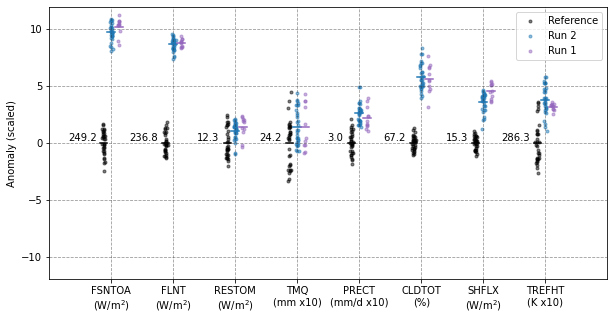

In [52]:
from matplotlib import pyplot
from e3smplot.e3sm_utils import get_data, get_area_weights, area_average
import numpy
variables = ('FSNTOA', 'FLNT', 'RESTOM', 'TMQ', 'PRECT', 'CLDTOT', 'SHFLX', 'TREFHT')
ref_cases = {
    'FSNTOA': 'CERES-SYN',
    'FLNT'  : 'CERES-SYN',
    'RESTOM': 'CERES-SYN',
    'TMQ'   : 'ERA5',
    'PRECT' : 'ERA5',
    'CLDTOT': 'CERES-SYN',
    'SHFLX' : 'ERA5',
    'TREFHT': 'ERA5',
}
colors = {
    'Run 2'    : 'tab:blue',
    'Run 1'    : 'tab:purple',
    'ne4pg2'   : 'tab:green',
    'CERES-SYN': 'black',
    'ERA5'     : 'black',
    'Reference': 'black',
}
scale_factors = {
    'TMQ': 10,
    'PRECT': 10,
    'TREFHT': 10,
}
units = {
    'FSNTOA': 'W/m$^2$',
    'FLNT'  : 'W/m$^2$',
    'RESTOM': 'W/m$^2$',
    'TMQ'   : 'mm',
    'PRECT' : 'mm/d',
    'CLDTOT': '%',
    'SHFLX' : 'W/m$^2$',
    'TREFHT': 'K',
}
test_cases = ('Run 2', 'Run 1')#'ne4pg2')
# Get time range to plot over
v = variables[0]
files = [f for f in glob(f'{data_paths[test_case_name]}/{glob_strings[test_case_name][v]}') if can_retrieve_field(f, v)]
with open_dataset(files, chunks={'time': 1}) as ds:
    t1 = str(min(ds.time.values))
    t2 = str(max(ds.time.values))
    
print(f'Computing anomalies for time period {t1:s} to {t2:s}')

labeled_cases = []
figure, ax = pyplot.subplots(1,1, figsize=(10, 5))
for ivar, v in enumerate(variables):
    for icase, case in enumerate((ref_cases[v], *test_cases)):
        print(case, v)

        # Find files
        files = [f for f in glob(f'{data_paths[case]}/{glob_strings[case][v]}') if can_retrieve_field(f, v)]
        
        # Read data
        with open_dataset(files, chunks={'time': 1}) as ds:
            
            # grab data
            da = get_data(ds, v)
            wt = get_area_weights(ds)
            
            # Subset data in time
            da = da.sel(time=slice(t1, t2))
            if 'time' in wt.dims: wt = wt.sel(time=slice(t1, t2))
            
            # Compute a time-series of area-means
            a = area_average(da, wt, dims=[d for d in da.dims if d != 'time'])
                    
            # Compute daily averages
            a = a.resample(time='1D').mean(keep_attrs=True)           
    
            # Scale by scale factor to put all values on same yaxis scale
            #if v in scale_factors.keys(): a.values = scale_factors[v] * a.values
            
            # Compute mean for control case; used to compute relative anomalies from reference means
            a_mean = a.mean().values
            if icase == 0: a_cntl = a_mean
                
            # Compute anomaly and maybe scale
            yvals = (a - a_cntl).values #/ abs(a_cntl)).values
            if v in scale_factors.keys(): yvals = [scale_factors[v] * y for y in yvals]
            
            # Define x-axis location for each variable/case. Optionally add some jitter to
            # the x-axis locations to scatter points horizontally a little so that we can
            # see them all without overlapping too much.
            #xvals = ((ivar + 1) * numpy.ones(len(a)) + (icase) * 0.1)
            dx = 1.0 / len(variables)
            xloc = ivar + (icase * dx)
            xvals = numpy.random.normal(loc=xloc, size=len(a), scale=dx/10)

            # Get labels; use "Reference" for the control cases
            if icase == 0:
                label = 'Reference'
            else:
                label = case
            # Make sure we only label each case once
            if label in labeled_cases:
                label=None
            else:
                labeled_cases.append(label)
            
            # Make scatter plot of relative anomalies
            pl1 = ax.scatter(xvals, yvals, marker='.', alpha=0.5, color=colors[case], label=label)
            #pl2 = ax2.scatter(xvals, yvals, marker='.', alpha=0.5, color=colors[case], label=None)
            
            # Plot mean as a small bar
            y = numpy.mean(yvals)
            pl2  = ax.plot([xloc - dx/2.0, xloc + dx/2.0], [y, y], color=colors[case], label=None)
            # Label means for control case
            if icase == 0: 
                ax.text(xvals[0] - dx,  0.001, f'{a_cntl:.1f}', ha='right', va='bottom')
                #ax.text(xvals[0] - dx, -0.001, f'{da.attrs["units"]:^10s}', ha='right', va='top')

    if v not in units.keys(): 
        print(f'adding unit {a.units} for {v}')
        units[v] = a.units
    
ax.set_ylabel('Anomaly (scaled)')
ax.set_ylim([-max(abs(numpy.array(ax.get_ylim()))), max(abs(numpy.array(ax.get_ylim())))])
xticks = [i + dx * (len(test_cases)) / 2.0 for i in range(len(variables))]
ax.set_xticks(xticks)
ax.set_xlim([xticks[0]-1, xticks[-1]+1])
ax.set_xticklabels([f'{v}\n({units[v]} x{scale_factors[v]})' 
                    if v in scale_factors.keys() 
                    else f'{v}\n({units[v]})' for v in variables])
ax.grid(axis='both', color='0.2', alpha=0.5, linestyle='dashed')
ax.legend(loc='best')
figure.savefig('scatter_test.png', bbox_inches='tight')

In [54]:
figure.savefig(f'{graphics_root}/Run2_anomalies.png', bbox_inches='tight', dpi=800)

## Contour maps

In [39]:
if do_contour_maps:
    for vname in variables:
        # For map plots we only compare two at a time so we can look at differences
        for cntl_case_name in cntl_case_names:
            
            print(f'Making {test_case_name} vs {cntl_case_name} contour maps for {vname}...')
            
            # Find files and make sure we can retrieve variable
            if vname not in glob_strings[test_case_name] or vname not in glob_strings[cntl_case_name]: continue
            test_files = sorted([f for f in glob(f'{data_paths[test_case_name]}/{glob_strings[test_case_name][vname]}')
                                 if can_retrieve_field(f, vname)])
            cntl_files = sorted([f for f in glob(f'{data_paths[cntl_case_name]}/{glob_strings[cntl_case_name][vname]}')
                                 if can_retrieve_field(f, vname)])
            if len(test_files) == 0:
                print(f'  Could not find {vname} in {test_case_name} files; skipping.')
                continue
            elif len(cntl_files) == 0:
                print(f'  Could not find {vname} in {cntl_case_name} files; skipping.')
                continue

            # Figure out what mapping files we need based on test and obs data
            if get_grid_name(test_files[0]) != get_grid_name(cntl_files[0]):
                map_file = get_mapping_file(test_files[0], cntl_files[0], mapping_root)
            else:
                map_file = None
            
            # Compare maps
            figname = f'{graphics_root}/maps/{vname}_{test_case_name.replace(" ", "_")}_vs_{cntl_case_name.replace(" ", "_")}_maps.png'
            os.makedirs(os.path.dirname(figname), exist_ok=True)
            compare_maps.main(
                test_files, cntl_files, vname, figname,
                test_name=test_case_name, cntl_name=cntl_case_name,
                time_offsets=(time_offsets[test_case_name], time_offsets[cntl_case_name]),
                map_file=map_file,
                lbAutoManage=False, 
                lbTitleFontHeightF=0.02, 
                lbLabelFontHeightF=0.02,
            )
    print('Done making maps.'); sys.stdout.flush()

Making Run 2 vs CERES-SYN contour maps for RESTOM...


/global/u1/b/bhillma/codes/scream/analysis/e3smplot/e3smplot/e3sm_utils.py:225: UserWarning: Using FSNTOA instead of FSNT
  data = get_data(ds, 'FSNTOA')
/global/u1/b/bhillma/codes/scream/analysis/e3smplot/e3smplot/e3sm_utils.py:225: UserWarning: Using FSNTOA instead of FSNT
  data = get_data(ds, 'FSNTOA')
/global/u1/b/bhillma/codes/scream/analysis/e3smplot/e3smplot/e3sm_utils.py:225: UserWarning: Using FSNTOA instead of FSNT
  data = get_data(ds, 'FSNTOA')
/global/u1/b/bhillma/codes/scream/analysis/e3smplot/e3smplot/e3sm_utils.py:225: UserWarning: Using FSNTOA instead of FSNT
  data = get_data(ds, 'FSNTOA')
/global/u1/b/bhillma/codes/scream/analysis/e3smplot/e3smplot/e3sm_utils.py:225: UserWarning: Using FSNTOA instead of FSNT
  data = get_data(ds, 'FSNTOA')
/global/u1/b/bhillma/codes/scream/analysis/e3smplot/e3smplot/e3sm_utils.py:225: UserWarning: Using FSNTOA instead of FSNT
  data = get_data(ds, 'FSNTOA')
/global/u1/b/bhillma/codes/scream/analysis/e3smplot/e3smplot/e3sm_utils.py:2

Making Run 2 vs ERA5 contour maps for RESTOM...
Done making maps.


In [18]:
test_files = sorted([f for f in glob(f'{data_paths["Run 2"]}/{glob_strings["Run 2"]["RESTOM"]}')
                                 if can_retrieve_field(f, 'RESTOM')])

In [20]:
f = glob(f'{data_paths["Run 2"]}/{glob_strings["Run 2"]["RESTOM"]}')

In [22]:
f = '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127/regridded/SCREAMv0.SCREAM-DY2.ne1024pg2.20201127.eam.h2.2020-02-16-00000.nc'


In [23]:
ds = open_dataset(f, chunks={'time': 1})

In [38]:
from e3smplot.e3sm_utils import get_data
d = get_data(ds, 'FSNT')

/global/u1/b/bhillma/codes/scream/analysis/e3smplot/e3smplot/e3sm_utils.py:225: UserWarning: Using FSNTOA instead of FSNT
  data = get_data(ds, 'FSNTOA')


## Zonal means

In [ ]:
if do_zonal_means:
    for vname in variables:
        # Find files and make sure we can retrieve variable
        files, names = zip(*[
            (sorted(glob(f'{data_paths[n]}/{glob_strings[n][vname]}')), n)
            for n in [test_case_name, *cntl_case_names]
            if vname in glob_strings[n]
        ])
        # Only files we can find variable name in
        #files, names = zip(*[(f,n) if can_retrieve_field(f, vname) else (None, None) 
        #                     for (f,n) in zip(files, names)])
        ffiles = []
        nnames = []
        for file_list, name in zip(files, names):
            files_with_var = [f for f in file_list if can_retrieve_field(f, vname)]
            if len(files_with_var) > 0:
                ffiles.append(files_with_var)
                nnames.append(name)
        files, names = ffiles, nnames
        if len(files) < 2: continue
        
        # Figure out what mapping files we need based on test and obs data
        default_grid_file = sorted(glob(f'{data_paths["CERES-SYN"]}/*.nc'))[0]
        maps = [get_mapping_file(f[0], default_grid_file, mapping_root)
                if not is_latlon(f[0]) else None for f in files]
        
        # Make zonal mean plots
        print(f'Making zonal mean plots for {vname}...')
        figname = f'{graphics_root}/zonal/{vname}_{test_case_name.replace(" ", "_")}_vs_all_zonal.png'
        os.makedirs(os.path.dirname(figname), exist_ok=True)
        compare_zonal_means.main(
            files, names, vname, figname,
            maps=maps, time_offsets=[time_offsets[n] for n in names],
        )

## Time series of global means

In [7]:
if do_time_series:
    for vname in variables:
        # Find files and make sure we can retrieve variable
        files, names = zip(*[
            (sorted(glob(f'{data_paths[n]}/{glob_strings[n][vname]}')), n)
            for n in [test_case_name, *cntl_case_names]
            if vname in glob_strings[n]
        ])
        # Only files we can find variable name in
        #files, names = zip(*[(f,n) for (f,n) in zip(files, names) if  can_retrieve_field(f, vname)])
        ffiles = []
        nnames = []
        for file_list, name in zip(files, names):
            files_with_var = [f for f in file_list if can_retrieve_field(f, vname)]
            if len(files_with_var) > 0:
                ffiles.append(files_with_var)
                nnames.append(name)
        files, names = ffiles, nnames
        if len(files) == 0: continue

        # Make time series plots
        print(f'Making time series for {vname}...')
        figname = f'{graphics_root}/time_series/{vname}_{test_case_name.replace(" ", "_")}_vs_all_timeseries.png'
        os.makedirs(os.path.dirname(figname), exist_ok=True)
        #if min([get_data(open_dataset(f), vname).min().values for f in files]) > 0: kwargs['ymin'] = 0
        compare_time_series.main(files, vname, figname, names, time_offsets=[time_offsets[n] for n in names])

Making time series for RESTOM...


/global/u1/b/bhillma/codes/scream/analysis/e3smplot/e3smplot/e3sm_utils.py:225: UserWarning: Using FSNTOA instead of FSNT
  warnings.warn('Using FSNTOA instead of FSNT')
/global/u1/b/bhillma/codes/scream/analysis/e3smplot/e3smplot/e3sm_utils.py:225: UserWarning: Using FSNTOA instead of FSNT
  warnings.warn('Using FSNTOA instead of FSNT')


In [ ]:
print('foo')